Having prepared the data in SQL, I will now make a short analysis of Chicago's most popular taxi companies in November 2017 and the most frequently visited destinations in the same month. Finally, I will test whether the travel duration between the Loop and the O'Hare Airport changes when it rains. 

## Study the General Information

In [163]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import scipy.stats as st 
import math as mt 
import matplotlib.pyplot as plt  

sql1= pd.read_csv('/datasets/project_sql_result_01.csv')
sql2= pd.read_csv('/datasets/project_sql_result_04.csv')

sql1.info()
sql1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company_name    64 non-null object
trips_amount    64 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [164]:
sql2.info()
sql2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
dropoff_location_name    94 non-null object
average_trips            94 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


Looks like for these two tables all data is there as needed.  Let's now move on to the first part of the analysis. 

## Exploratory Data Analysis 

In [9]:
sql2.sort_values('average_trips', ascending= False).head(10)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


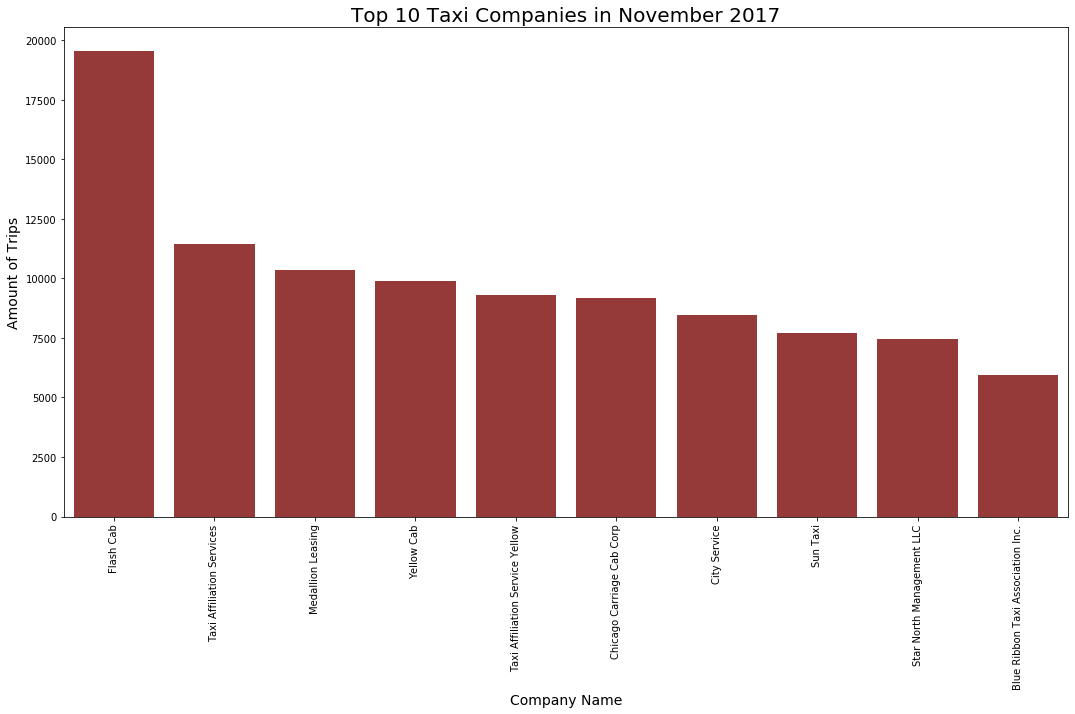

In [42]:
sort_sql1= sql1.sort_values('trips_amount', ascending= False).head(10)
fig, ax= plt.subplots(figsize=(18,9))
sns.barplot(data= sort_sql1, x= 'company_name', y= 'trips_amount', color= 'brown').set_title('Top 10 Taxi Companies in November 2017', size= 20)
plt.xlabel('Company Name', size= 14)
plt.ylabel('Amount of Trips', size= 14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The most popular companies are Flash Cab, Taxi Affiliation Services and Medaillon Leasing. It is remarkable that Flash Cab leads by a very large margin with more approx. 8000 trips more than the second-ranked company. This might be due to cheaper prices and a larger vehicle fleet. 

The least popular companies are Sun Taxi, Star North Management LLC and Blue Ribbon Taxi Association Inc. 

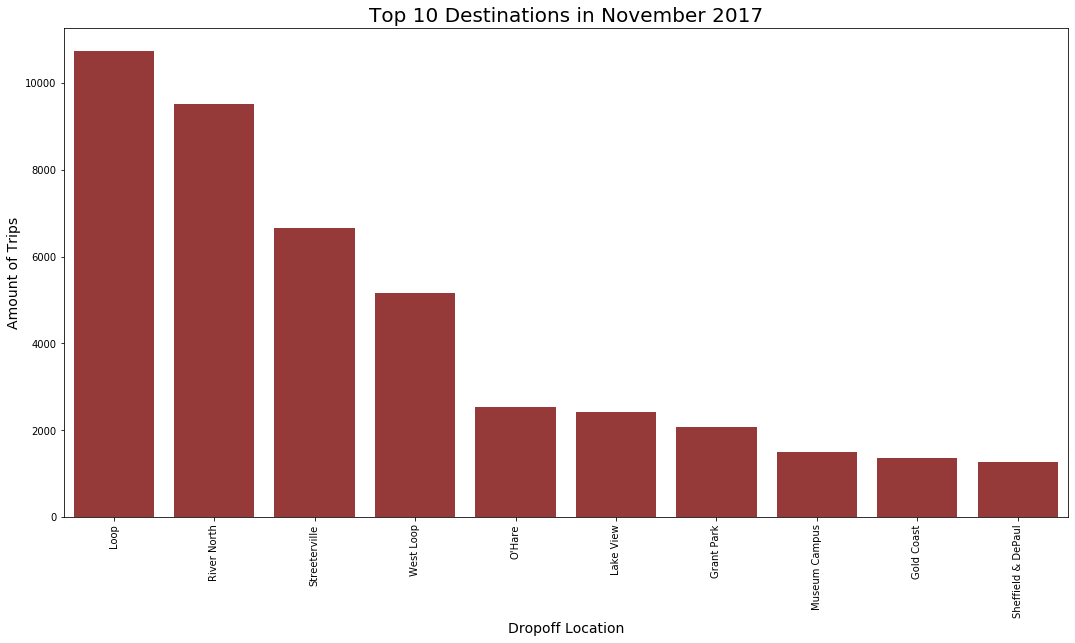

In [46]:
sort_sql2= sql2.sort_values('average_trips', ascending= False).head(10)
fig, ax= plt.subplots(figsize=(18,9))
sns.barplot(data= sort_sql2, x= 'dropoff_location_name', y= 'average_trips', color= 'brown').set_title('Top 10 Destinations in November 2017', size= 20)
plt.xlabel('Dropoff Location', size= 14)
plt.ylabel('Amount of Trips', size= 14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The most frequently occuring dropoff locations are Loop, River North and Streeterville.
The three least visited destinations are Museum Campus, Gold Coast and Sheffield & DePaul. 

Reasons for these patterns may be that the frequently visited locations are more densely populated than the lesser chosen locations. An alternative explanation could be that the locations differ in their accessibility with public transport. 

## Test Hypotheses 

This part tests the following Hypothesis: 

H1: "The average duration of rides from the Loop to O'Hare International Airport differs between rainy Saturdays and non-rainy Saturdays." 

H0: "The average duration of rides from the Loop to O'Hare International Airport does not differ between rainy Saturdays and non-rainy Saturdays." 

The mean durations of rainy saturdays and non-rainy saturdays will be compared and the difference will be tested for significance by means of a statistical test. 

To select the appropriate test, I'll test the distributions of both samples for normality and for the equality of their variances.  

In [67]:
sql3= pd.read_csv('/datasets/project_sql_result_07.csv')
sql3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
start_ts              1068 non-null object
weather_conditions    1068 non-null object
duration_seconds      1068 non-null float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [146]:
bad= sql3.query('weather_conditions == "Bad"')['duration_seconds']
num= bad.index.values
good= sql3.drop(num, axis= 0)['duration_seconds']

In [153]:
import scipy.stats as st 
st,p = st.shapiro(bad)
alpha = 0.05 

if p < alpha: 
    print('The rainy days data is not normally distributed')
else:
    print('The rainy days data is normally distributed')

The rainy days data is not normally distributed


In [152]:
import scipy.stats as st 
st,p = st.shapiro(good)
if p < alpha: 
    print('The good days data is not normally distributed')
else:
    print('The good days data is normally distributed')

The good days data is not normally distributed


Since the data of both samples is not normally distributed, we might skip looking for equal variances and directly use the rank-based Mann-Whitney-U test. 

However, since both samples are larger than 50, it might still be valid to use a regular t-test, given that the variances of both samples are equal. To keep this option open, I will run a levene test first. 

In [162]:
import scipy.stats as st 
st,p = st.levene(bad, good)

if p < alpha: 
    print('The variances are unequal')
else:
    print('The variances are equal')

The variances are equal


As the Levene test shows, the variances of both tests are equal. Thus a regular ttest might be sufficient to get reliable results. 
I decided to use both, Mann-Whitney-U and t-test to test the hypothesis. 

In [159]:
print('Mean duration on rainy days',bad.mean())
print('Mean duration on good days',good.mean())
print('Median duration on rainy days',bad.median())
print('Median duration on good days',good.median() )

results= st.mannwhitneyu(bad,good)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('we reject the null hypothesis')
else: 
    print('We accept the null hypothesis')

Mean duration on rainy days 2427.2055555555557
Mean duration on good days 1999.6756756756756
Median duration on rainy days 2540.0
Median duration on good days 1800.0
p-value: 3.358269442796729e-14
we reject the null hypothesis


In [161]:
import scipy.stats as st 
print('Mean duration on rainy days',bad.mean())
print('Mean duration on good days',good.mean())
print('Median duration on rainy days',bad.median())
print('Median duration on good days',good.median() )

results= st.ttest_ind(bad,good)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('we reject the null hypothesis')
else: 
    print('We accept the null hypothesis')

Mean duration on rainy days 2427.2055555555557
Mean duration on good days 1999.6756756756756
Median duration on rainy days 2540.0
Median duration on good days 1800.0
p-value: 6.517970327099473e-12
we reject the null hypothesis


Both Mann-Whitney and T-Test show that the means between sunny and rainy days are signifcantly different. 

Looking at the results, we can conclude that in terms of mean rainy rides take roughly 7 mins longer than sunny rides (mean difference/60). In terms of median the difference is even much larger with 12 mins (median difference/60). 

## Conclusion 

This short enquiry into the Chicago taxi industry has yielded the following results:

**On 15th and 16th November 2017, the most popular taxi companies in Chicago were:** 
    1. Flash Cab
    2. Taxi Affiliation Services 
    3. Medaillon Leasing. 
    
**During the same time period the least popular taxi companies in Chicago were:** 
    1. Sun Taxi
    2. Star North Management LLC 
    3. Blue Ribbon Taxi Association Inc. 

**The most frequently visited neighborhoods in November 2017 were:**
    1. Loop
    2. River North
    3. Streeterville 
  

**The least frequently visited neighborhoods in November 2017 were:**
    1. Museum Campus
    2. Gold Coast 
    3. Sheffield & DePaul

**On average, travelling from the Loop to O'Hare Airport takes longer on rainy and stormy days (p<0.05):** 
    - Mean duration sunny days (in minutes): approx. 33 mins
    - Mean duration rainy days (in minutes): approx. 40 mins
    - Median duration sunny days (in minutes): approx. 42 mins
    - Mean duration rainy days (in minutes): approx. 30 mins
    